# Dynamics Derivation

In [14]:
import sympy as sym
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
sym.init_printing()

In [15]:
# Dynamics Derivation using calculated constants
mass = 0.6052    # The mass of the quadrotor in kg
Ixx = 0.01135453  # The moment of inertia of the quadrotor in 
Iyy = 0.01209302  # The mass of the quadrotor in kg
Izz = 0.01173394  # The mass of the quadrotor in kg
grav = 9.80665 # The acceleration due to gravity on Earth

# Define the state variables
initial_state = [0.0, 0.0, 0.0,  # Initial position: (0,0,0)
                 0.0, 0.0, 0.0,  # Initial velocity: (0,0,0)
                 0.0, 0.0, 0.0,  # Initial roll, pitch, yaw angles: (0,0,0)
                 0.0, 0.0, 0.0]  # Initial angular velocities: (0,0,0)

px_inW, py_inW, pz_inW = sym.symbols('p_x, p_y, p_z')
p_inW = sym.Matrix([[px_inW],
                    [py_inW],
                    [pz_inW]])

vx_inB, vy_inB, vz_inB = sym.symbols('v_x, v_y, v_z')
v_inB = sym.Matrix([[vx_inB],
                    [vy_inB],
                    [vz_inB]])

phi, theta, psi = sym.symbols('phi, theta, psi')

wx_inB, wy_inB, wz_inB = sym.symbols('omega_x, omega_y, omega_z')
w_inB = sym.Matrix([[wx_inB],
                    [wy_inB],
                    [wz_inB]])

Rx = sym.Matrix([[1,            0,             0],
                 [0, sym.cos(phi), -sym.sin(phi)],
                 [0, sym.sin(phi),  sym.cos(phi)]])
Ry = sym.Matrix([[ sym.cos(theta), 0, sym.sin(theta)],
                 [              0, 1,              0],
                 [-sym.sin(theta), 0, sym.cos(theta)]])
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0],
                 [sym.sin(psi),  sym.cos(psi), 0],
                 [           0,             0, 1]])
R_ofB_inW = Rz @ Ry @ Rx
R_ofW_inB = R_ofB_inW.T

taux_inB, tauy_inB, tauz_inB, fz_inB = sym.symbols('tau_x, tau_y, tau_z, f_z')

tau_inB = sym.Matrix([[taux_inB],
                      [tauy_inB],
                      [tauz_inB]])
tau_inB = sym.simplify(tau_inB)

grav_inW = sym.Matrix([[0.],
                       [0.],
                       [-mass * grav]])
grav_inB = R_ofW_inB @ grav_inW

f_inB = grav_inB + sym.Matrix([[0.],
                               [0.],
                               [fz_inB]])
f_inB = sym.simplify(f_inB)

I_inB = sym.Matrix([[Ixx, 0.,  0.],
                    [0.,  Iyy, 0.],
                    [0.,  0.,  Izz]])

v_inW = R_ofB_inW @ v_inB
xyz_dot = sym.simplify(v_inW)

v_inB_dot = (1 / mass) * (f_inB - w_inB.cross(mass * v_inB))
v_inB_dot = sym.simplify(v_inB_dot)

ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.Matrix.hstack(ex, Rx.T@ey, (Ry@Rx).T@ez)

M_inv = sym.simplify(M.inv())

rpy_dot = sym.simplify(M_inv@w_inB)

w_inB_dot = I_inB.inv() @ (tau_inB - w_inB.cross(I_inB@w_inB))
w_inB_dot = sym.simplify(w_inB_dot)

f = sym.Matrix.vstack(xyz_dot,
                      v_inB_dot,
                      rpy_dot,
                      w_inB_dot)
sym.N(f,3)

⎡vₓ⋅cos(ψ)⋅cos(θ) + v_y⋅(sin(φ)⋅sin(θ)⋅cos(ψ) - sin(ψ)⋅cos(φ)) + v_z⋅(sin(φ)⋅s
⎢                                                                             
⎢vₓ⋅sin(ψ)⋅cos(θ) + v_y⋅(sin(φ)⋅sin(ψ)⋅sin(θ) + cos(φ)⋅cos(ψ)) - v_z⋅(sin(φ)⋅c
⎢                                                                             
⎢                            -vₓ⋅sin(θ) + v_y⋅sin(φ)⋅cos(θ) + v_z⋅cos(φ)⋅cos(θ
⎢                                                                             
⎢                                   -ω_y⋅v_z + 1.0⋅ω_z⋅v_y + 9.81⋅sin(θ)      
⎢                                                                             
⎢                                 1.0⋅ωₓ⋅v_z - ω_z⋅vₓ - 9.81⋅sin(φ)⋅cos(θ)    
⎢                                                                             
⎢                           1.65⋅f_z - ωₓ⋅v_y + 1.0⋅ω_y⋅vₓ - 9.81⋅cos(φ)⋅cos(θ
⎢                                                                             
⎢                                ωₓ + ω_y⋅sin(φ)⋅tan

In [16]:
def quadrotor_dynamics(t, state, control_inputs):
    # Extract the state variables
    px, py, pz, vx, vy, vz, phi, theta, psi, wx, wy, wz = state

    # Unpack control inputs
    tau_x, tau_y, tau_z, f_z = control_inputs

    # Calculate the moment of inertia matrix
    I_inB = np.array([[Ixx, 0, 0],
                      [0, Iyy, 0],
                      [0, 0, Izz]])

    # Calculate the rotation matrix from body to world frame
    Rx = np.array([[1, 0, 0],
                   [0, np.cos(phi), -np.sin(phi)],
                   [0, np.sin(phi), np.cos(phi)]])
    Ry = np.array([[np.cos(theta), 0, np.sin(theta)],
                   [0, 1, 0],
                   [-np.sin(theta), 0, np.cos(theta)]])
    Rz = np.array([[np.cos(psi), -np.sin(psi), 0],
                   [np.sin(psi), np.cos(psi), 0],
                   [0, 0, 1]])
    R_ofB_inW = Rz @ Ry @ Rx
    R_ofW_inB = R_ofB_inW.T

    # Calculate gravity force in world frame and transform to body frame
    grav_inW = np.array([0, 0, -mass * grav])
    grav_inB = R_ofW_inB @ grav_inW

    # Calculate the force in body frame
    f_inB = grav_inB + np.array([0, 0, f_z])

    # Calculate linear acceleration in body frame
    v_inB = np.array([vx, vy, vz])
    v_inB_dot = (1 / mass) * (f_inB - np.cross([wx, wy, wz], mass * v_inB))

    # Compute the transformation matrix M and its inverse
    ex = np.array([[1], [0], [0]])
    ey = np.array([[0], [1], [0]])
    ez = np.array([[0], [0], [1]])
    M = np.hstack((ex, Rx.T @ ey, (Ry @ Rx).T @ ez))
    M_inv = np.linalg.inv(M)

    # Calculate roll, pitch, and yaw rates
    rpy_dot = M_inv @ np.array([wx, wy, wz])

    # Calculate angular acceleration in body frame
    w_inB = np.array([wx, wy, wz])
    w_inB_dot = np.linalg.inv(I_inB) @ (np.array([tau_x, tau_y, tau_z]) - np.cross(w_inB, I_inB @ w_inB))
    
    # Calculate the linear velocity in the world frame
    v_inW = R_ofB_inW @ v_inB
    xyz_dot = np.hstack(v_inW)

    # Combine state derivatives
    state_dot = np.hstack([xyz_dot, v_inB_dot, rpy_dot, w_inB_dot])

    return state_dot


In [17]:
class Quadrotor_Sim_PID_Controller:
    def __init__(self, Kp, Ki, Kd, thrust_limits):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.integral = 0.0
        self.prev_error = 0.0
        self.thrust_limits = thrust_limits  # (min_thrust, max_thrust)

    def control(self, current_error, dt):
        # Proportional term
        P = self.Kp * current_error
        
        # Integral term
        self.integral += current_error * dt
        
        # Prevent integral windup by clamping the integral term
        self.integral = np.clip(self.integral, -1, 1)
        
        I = self.Ki * self.integral
        
        # Derivative term
        D = self.Kd * ((current_error - self.prev_error) / dt)
        
        # Update the previous error
        self.prev_error = current_error
        
        # Total control output
        control_output = P + I + D
        
        return control_output

def control_hover_1m(state, dt):
    # Desired altitude
    desired_height = 1.0
    
    # Calculate the error in height
    height_error = desired_height - state[2]
    
    # Compute PID control
    thrust_control = pid_controller.control(height_error, dt)
    
    # Calculate thrust limits
    thrust = mass * grav + thrust_control * mass
    
    # Clamp the thrust
    thrust = np.clip(thrust, 0.0, 2 * mass * grav)
    
    # Zero torques for hovering
    tau_x = 0.0
    tau_y = 0.0
    tau_z = 0.0
    
    return [tau_x, tau_y, tau_z, thrust]

# Define thrust limits for the PID controller
thrust_limits = (0.0, 2 * mass * grav)  # Min and max thrust limits

# Initialize the PID controller with gains and thrust limits
Kp = 0.4  # Proportional gain
Ki = 0.005  # Integral gain 
Kd = 5.0  # Derivative gain
pid_controller = Quadrotor_Sim_PID_Controller(Kp, Ki, Kd, thrust_limits)

# Simulation setup
t_span = (0, 150)
t_eval = np.linspace(t_span[0], t_span[1], num=1200)  

# Solve the ODE with the control function for hovering
solution = solve_ivp(lambda t, state: quadrotor_dynamics(t, state, control_hover_1m(state, t_eval[1] - t_eval[0])),
                     t_span, initial_state, method='RK45', t_eval=t_eval)

# Extract results
time = solution.t
px, py, pz = solution.y[0], solution.y[1], solution.y[2]


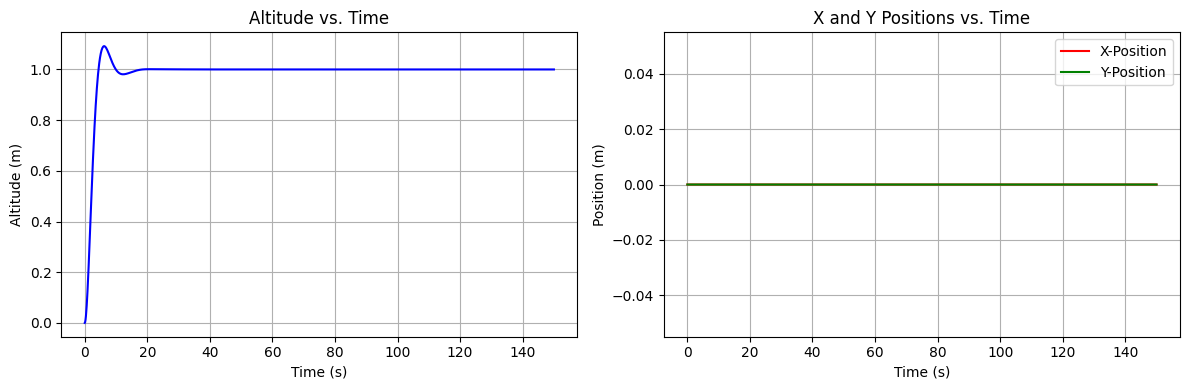

In [18]:
import matplotlib.pyplot as plt

def plot_quadrotor_2d_positions(time, state):
    """
    Plots the altitude over time and x-y positions over time in a 2x1 grid layout.
    
    Parameters:
    time (array): Array of time points.
    state (array): Array of state variables over time.
                   Columns represent [px, py, pz, vx, vy, vz, phi, theta, psi, wx, wy, wz].
    """
    # Extract positions and altitude from the state array
    px, py, pz = state[0], state[1], state[2]
    
    # Create a figure with a 1x2 grid layout for the plots
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # Plot altitude over time in the top subplot
    axs[0].plot(time, pz, color='b')
    axs[0].set_title('Altitude vs. Time')
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Altitude (m)')
    axs[0].grid(True)

    # Plot x and y positions over time in the bottom subplot
    axs[1].plot(time, px, label='X-Position', color='r')
    axs[1].plot(time, py, label='Y-Position', color='g')
    axs[1].set_title('X and Y Positions vs. Time')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Position (m)')
    axs[1].grid(True)
    axs[1].legend()

    # Display the plots
    plt.tight_layout()
    plt.show()

# Call the function with the simulation results
plot_quadrotor_2d_positions(time, solution.y)


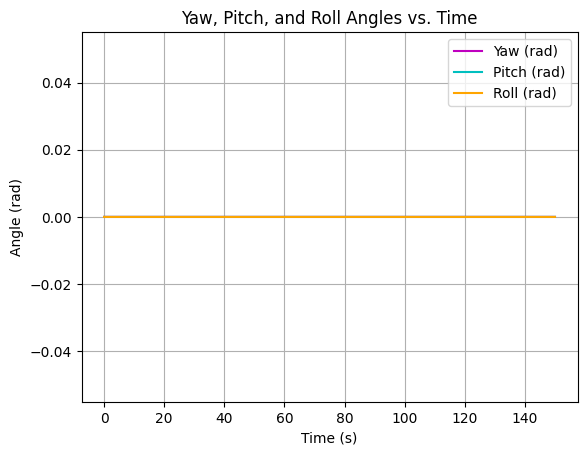

In [19]:
import matplotlib.pyplot as plt

def plot_quadrotor_angles(time, state):
    """
    Plots the yaw, pitch, and roll angles over time.
    
    Parameters:
    time (array): Array of time points.
    state (array): Array of state variables over time.
                   Columns represent [px, py, pz, vx, vy, vz, phi, theta, psi, wx, wy, wz].
    """
    # Extract yaw, pitch, and roll angles from the state array
    phi, theta, psi = state[6], state[7], state[8]
    
    # Create a new figure for the angles plot
    plt.figure()
    # Plot yaw, pitch, roll angles over time
    plt.plot(time, psi, label='Yaw (rad)', color='m')
    plt.plot(time, theta, label='Pitch (rad)', color='c')
    plt.plot(time, phi, label='Roll (rad)', color='orange')
    plt.title('Yaw, Pitch, and Roll Angles vs. Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Angle (rad)')
    plt.grid(True)
    plt.legend()
    
    # Display the plot
    plt.show()

# Call the function with the simulation results
plot_quadrotor_angles(time, solution.y)


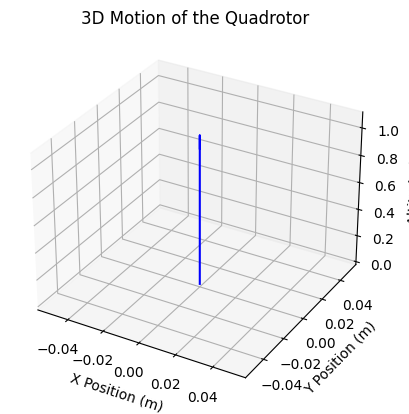

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_quadrotor_3d_trajectory(px, py, pz):
    """
    Plots the 3D trajectory of the quadrotor over time.
    
    Parameters:
    px (array): Array of x positions over time.
    py (array): Array of y positions over time.
    pz (array): Array of z positions (altitude) over time.
    """
    # Create a new figure for the 3D plot
    fig = plt.figure()
    ax_3d = fig.add_subplot(111, projection='3d')
    
    # Plot the 3D trajectory
    ax_3d.plot(px, py, pz, color='b')
    ax_3d.set_title('3D Motion of the Quadrotor')
    ax_3d.set_xlabel('X Position (m)')
    ax_3d.set_ylabel('Y Position (m)')
    ax_3d.set_zlabel('Altitude (m)')
    
    # Display the plot
    plt.show()

# Call the function with the simulation results
plot_quadrotor_3d_trajectory(solution.y[0], solution.y[1], solution.y[2])


In [21]:
def control_hover_in_circle(state, dt, t):
    """
    Control function to hover the quadrotor in a circle of radius 2m,
    at an altitude of 1m above ground, and at a speed of 0.5m/s for at least 1 minute.
    
    Parameters:
    state (list): Current state of the quadrotor.
    dt (float): Time step.
    t (float): Current time.
    
    Returns:
    list: Control inputs [tau_x, tau_y, tau_z, f_z].
    """
    # Desired altitude and circular path parameters
    desired_height = 1.0
    radius = 2.0
    speed = 0.5  # m/s

    # Calculate desired positions and angles
    angular_speed = speed / radius
    desired_x = radius * np.cos(angular_speed * t)
    desired_y = radius * np.sin(angular_speed * t)
    desired_yaw = np.arctan2(desired_y, desired_x)

    # Calculate errors in position and orientation
    error_x = desired_x - state[0]  # X position error
    error_y = desired_y - state[1]  # Y position error
    error_yaw = desired_yaw - state[8]  # Yaw angle error

    # Control gains
    Kp_pos = 1.0
    Kp_yaw = 0.5

    # Calculate control efforts for position and yaw
    vy_control = Kp_pos * error_x
    vx_control = Kp_pos * error_y
    yaw_control = Kp_yaw * error_yaw

    # Calculate torques based on control efforts
    tau_x = vy_control * Iyy
    tau_y = vx_control * Ixx
    tau_z = yaw_control * Izz

    # Calculate the thrust
    height_error = desired_height - state[2]
    thrust_control = pid_controller.control(height_error, dt)
    thrust = mass * grav + thrust_control * mass
    
    # Clamp thrust
    thrust = np.clip(thrust, 0.0, 2 * mass * grav)
    
    # Return control inputs (torques and thrust)
    return [tau_x, tau_y, tau_z, thrust]


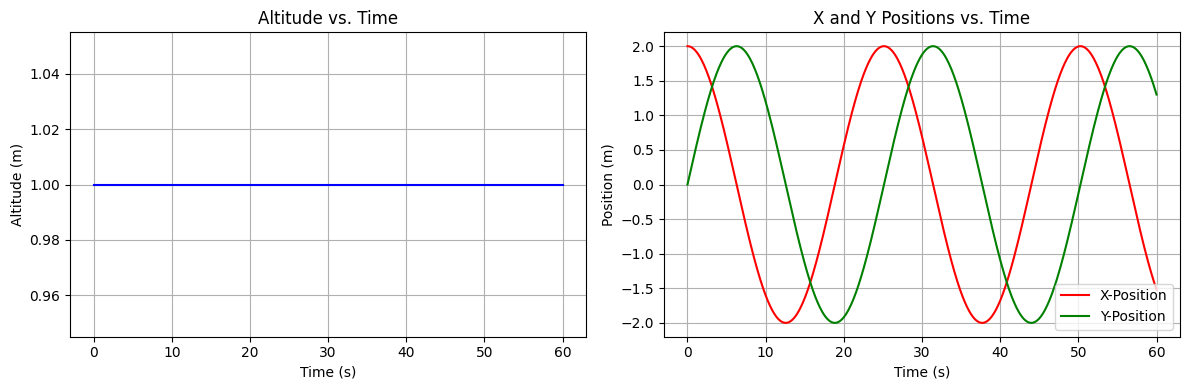

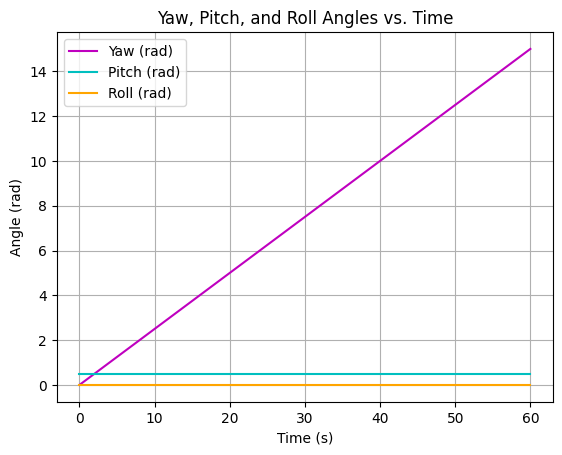

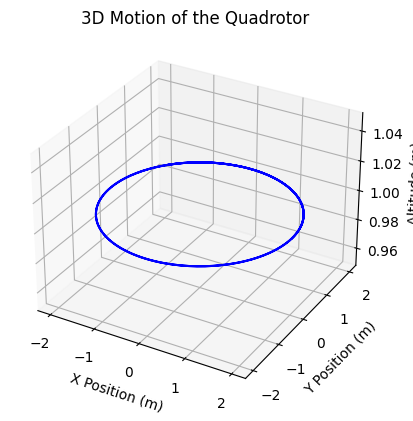

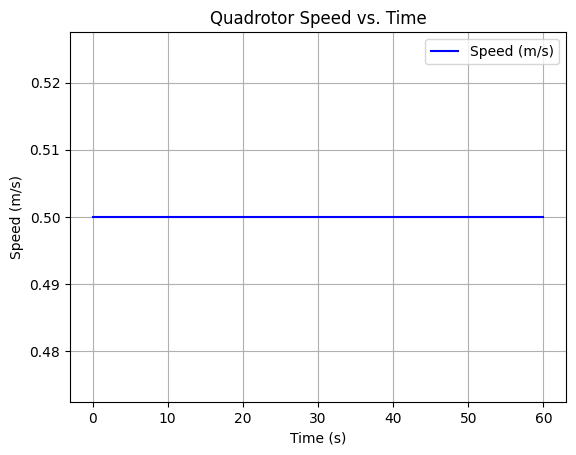

In [12]:
t_span = (0, 60)  # Simulate for 1 minute

t_eval = np.linspace(t_span[0], t_span[1], num=600)

rtol = 1e-2
atol = 1e-5

# Solve the ODE with the control function for hovering in a circle
solution = solve_ivp(lambda t, state: quadrotor_dynamics(t, state, control_hover_in_circle(state, t_eval[1] - t_eval[0], t)),
                     t_span, initial_state, method='RK45', t_eval=t_eval, rtol=rtol, atol=atol)

time = solution.t
px, py, pz = solution.y[0], solution.y[1], solution.y[2]

def plot_quadrotor_linear_velocity(time, state):
    """
    Plots the linear velocity magnitude over time.
    
    Parameters:
    time (array): Array of time points.
    state (array): Array of state variables over time.
                   Columns represent [px, py, pz, vx, vy, vz, phi, theta, psi, wx, wy, wz].
    """
    # Extract linear velocities from the state array
    vx, vy, vz = state[3], state[4], state[5]
    
    # Calculate the linear velocity magnitude over time
    linear_velocity = np.sqrt(vx**2 + vy**2 + vz**2)
    
    # Create a new figure for the linear velocity plot
    plt.figure()
    
    # Plot the constant linear velocity over time
    plt.plot(time, linear_velocity, color='b', label='Speed (m/s)')
    plt.title('Quadrotor Speed vs. Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Speed (m/s)')
    plt.grid(True)
    plt.legend()
    
    # Display the plot
    plt.show()

# Call the functions to plot the data
plot_quadrotor_2d_positions(time, solution.y)
plot_quadrotor_angles(time, solution.y)
plot_quadrotor_3d_trajectory(px, py, pz)
plot_quadrotor_linear_velocity(time, solution.y)


In [ ]:
def control_path_following(t, state, dt, path_state):
    """
    Control function to follow a predefined path.
    
    Parameters:
    t (float): Current time in seconds.
    state (array): Current state of the quadrotor.
    dt (float): Time step in seconds.
    path_state (tuple): State information for the current path phase.
    
    Returns:
    list: Control inputs [tau_x, tau_y, tau_z, thrust] for the quadrotor.
    """
    ASCENT = 0
    STRAIGHT_1 = 1
    HOVER_1 = 2
    YAW = 3
    STRAIGHT_2 = 4
    HOVER_2 = 5
    LANDING = 6
    
    current_phase = path_state[0]
    
    if current_phase == ASCENT:
        return control_hover_1m(state, dt)
    elif current_phase == STRAIGHT_1:
        return control_straight_line(state, dt, distance=5, direction=np.array([1, 0, 0]))
    elif current_phase == HOVER_1:
        return control_hover_1m(state, dt)
    elif current_phase == YAW:
        return control_yaw_to_angle(state, dt, angle=-np.pi/2)
    elif current_phase == STRAIGHT_2:
        return control_straight_line(state, dt, distance=5, direction=np.array([0, 1, 0]))
    elif current_phase == HOVER_2:
        return control_hover_1m(state, dt)
    elif current_phase == LANDING:
        return control_landing(state, dt)
    
    return control_hover_1m(state, dt)


def control_straight_line(state, dt, distance, direction):
    """
    Control function to move the quadrotor in a straight line.
    
    Parameters:
    state (array): Current state of the quadrotor.
    dt (float): Time step in seconds.
    distance (float): Distance to travel.
    direction (array): Unit vector specifying the direction of movement.
    
    Returns:
    list: Control inputs [tau_x, tau_y, tau_z, thrust] for the quadrotor.
    """
    # Compute the desired end position
    start_pos = np.array([state[0], state[1], state[2]])
    desired_end_pos = start_pos + distance * direction
    
    # Compute position errors
    position_error = desired_end_pos - start_pos
    
    # Compute desired velocity to reach the end position
    desired_velocity = position_error / dt
    
    # Calculate velocity errors
    velocity_error = desired_velocity - np.array([state[3], state[4], state[5]])
    
    # Calculate control inputs using PID control (simplified)
    thrust_control = pid_controller.control(velocity_error[2], dt)
    thrust = mass * grav + thrust_control * mass
    
    # Compute torques
    tau_x = pid_controller.control(velocity_error[0], dt)
    tau_y = pid_controller.control(velocity_error[1], dt)
    tau_z = 0.0  # No yaw control needed here
    
    return [tau_x, tau_y, tau_z, thrust]


def control_yaw_to_angle(state, dt, angle):
    """
    Control function to adjust the yaw angle of the quadrotor.
    
    Parameters:
    state (array): Current state of the quadrotor.
    dt (float): Time step in seconds.
    angle (float): Desired yaw angle in radians.
    
    Returns:
    list: Control inputs [tau_x, tau_y, tau_z, thrust] for the quadrotor.
    """
    # Calculate the yaw error
    yaw_error = angle - state[8]
    
    # Normalize yaw error
    yaw_error = (yaw_error + np.pi) % (2 * np.pi) - np.pi
    
    # Use PID control for yaw adjustment
    tau_z = pid_controller.control(yaw_error, dt)
    
    # Zero roll and pitch torques
    tau_x = 0.0
    tau_y = 0.0
    
    # Hover at 1m while adjusting yaw
    thrust_control = pid_controller.control(state[2] - 1.0, dt)
    thrust = mass * grav + thrust_control * mass
    
    return [tau_x, tau_y, tau_z, thrust]


def control_landing(state, dt):
    """
    Control function for precise vertical landing.
    
    Parameters:
    state (array): Current state of the quadrotor.
    dt (float): Time step in seconds.
    
    Returns:
    list: Control inputs [tau_x, tau_y, tau_z, thrust] for the quadrotor.
    """
    # Desired landing speed (no more than 1 cm/s)
    desired_landing_speed = -0.01  # m/s
    
    # Calculate the vertical speed error
    vertical_speed_error = state[5] - desired_landing_speed
    
    # Use PID control to adjust vertical speed
    thrust_control = pid_controller.control(vertical_speed_error, dt)
    thrust = mass * grav + thrust_control * mass
    
    # Clamp the thrust
    thrust = max(0.0, thrust)
    
    # Zero torques for vertical landing
    tau_x = 0.0
    tau_y = 0.0
    tau_z = 0.0
    
    return [tau_x, tau_y, tau_z, thrust]

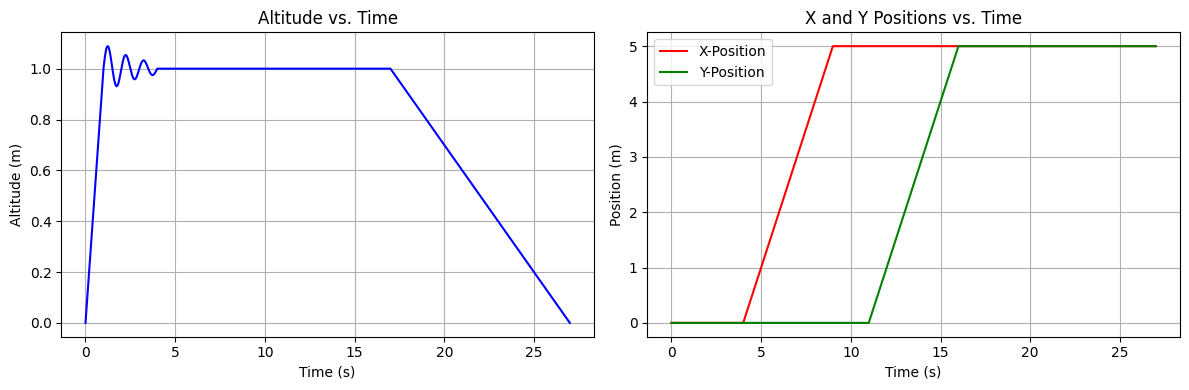

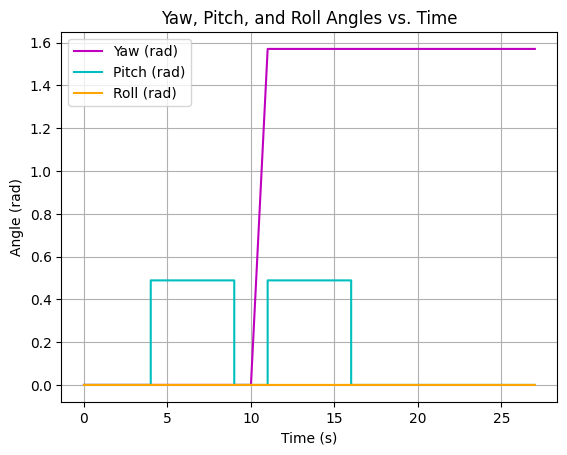

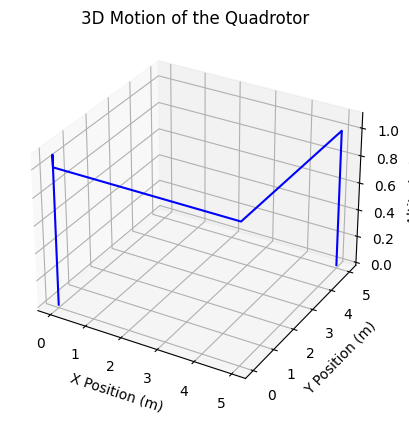

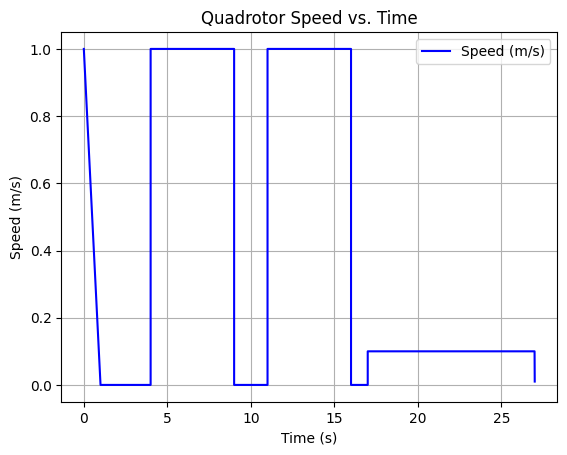

In [13]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define the path state phases and durations
ASCENT = 0
STRAIGHT_1 = 1
HOVER_1 = 2
YAW = 3
STRAIGHT_2 = 4
HOVER_2 = 5
LANDING = 6

# Define the phases and their durations (in seconds)
path_phases = [
    (ASCENT, 4),      # Ascent for 4 seconds
    (STRAIGHT_1, 5),  # Move straight for 5 seconds
    (HOVER_1, 2),     # Hover for 2 seconds
    (YAW, 0.001),     # Yaw 90 degrees to the left for 0.001 seconds
    (STRAIGHT_2, 5),  # Move straight for another 5 seconds
    (HOVER_2, 1),     # Hover for 1 seconds
    (LANDING, 10)     # Land for 10 seconds
]

def control_path(state, t, path_phases):
    """
    Control function to handle different phases of the path.
    
    Parameters:
    state (array): Current state of the quadrotor.
    t (float): Current time in seconds.
    path_phases (list): List of tuples representing path phases and their durations.
    
    Returns:
    list: Control inputs [tau_x, tau_y, tau_z, thrust] for the quadrotor.
    """
    current_time = t
    phase_index = 0
    accumulated_time = 0
    
    # Determine the current phase based on the time elapsed
    for i, (phase, duration) in enumerate(path_phases):
        accumulated_time += duration
        if current_time < accumulated_time:
            phase_index = i
            break
    
    # Get the current phase and its control function
    current_phase = path_phases[phase_index][0]
    
    # Call the control function based on the current phase
    return control_path_following(t, state, t_eval[1] - t_eval[0], (current_phase,))

# Simulation setup
t_span = (0, sum(duration for _, duration in path_phases))
t_eval = np.linspace(t_span[0], t_span[1], num=int(t_span[1] * 10))

solution = solve_ivp(lambda t, state: quadrotor_dynamics(t, state, control_path(state, t, path_phases)),
                     t_span, initial_state, method='RK45', t_eval=t_eval)

time = solution.t
px, py, pz = solution.y[0], solution.y[1], solution.y[2]
phi, theta, psi = solution.y[6], solution.y[7], solution.y[8]

# Call the functions to plot the data
plot_quadrotor_2d_positions(time, solution.y)
plot_quadrotor_angles(time, solution.y)
plot_quadrotor_3d_trajectory(px, py, pz)
plot_quadrotor_linear_velocity(time, solution.y)
